## Predicting Asteroid Diameter Using Statistical Machine Learning

This notebook follows the assessment stages:

- **Stage 1:** Data set and pre-processing  
- **Stage 2:** Data visualisation (correlations + two-variable plots)  
- **Stage 3:** Model implementation and evaluation  
- **Stage 4:** Model insights using SHAP values  

The target variable is the asteroid diameter (km). The goal is to build regression models that predict diameter from observational and orbital features in the NASA JPL dataset and then interpret the most important predictors.

In [2]:
# Install SHAP once per runtime (quiet mode)
!pip install shap -q

# Core libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression   # baseline linear model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import shap

# Display settings
plt.style.use("default")
pd.set_option("display.max_columns", None)
sns.set()


## Stage 1 – Data Set and Pre-Processing

The dataset used in this project is the cleaned asteroid data published with the
*Predicting Asteroid Diameter* project (Blakelobato, 2020) and sourced originally
from the NASA JPL Small-Body Database (NASA JPL SBDB).

The CSV already has substantial pre-processing applied:
- removal of irrelevant or duplicate columns,
- exclusion of many missing values and extreme outliers,
- restriction to asteroid-specific attributes.

In this stage I:
1. Load the CSV directly from the public GitHub repository.  
2. Inspect the first 25 rows to understand feature ranges and any remaining issues.  
3. Identify which columns are numeric and suitable for correlation and modelling.


In [3]:
# Load pre-processed asteroid dataset from GitHub
url = "https://raw.githubusercontent.com/blakelobato/Predicting-Asteroid-Diameter-Dash/master/model/Pred_Ast_Diam_2.csv"
df = pd.read_csv(url)

# Basic structure overview
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126497 entries, 0 to 126496
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   orbit_id         126497 non-null  object 
 1   e                126497 non-null  float64
 2   a                126497 non-null  float64
 3   i                126497 non-null  float64
 4   om               126497 non-null  float64
 5   w                126497 non-null  float64
 6   ma               126497 non-null  float64
 7   n                126497 non-null  float64
 8   tp               126497 non-null  float64
 9   moid             126497 non-null  float64
 10  moid_jup         126497 non-null  float64
 11  class            126497 non-null  object 
 12  producer         126497 non-null  object 
 13  data_arc         126497 non-null  float64
 14  n_obs_used       126497 non-null  int64  
 15  rms              126497 non-null  float64
 16  diameter         126497 non-null  floa

In [4]:
# Show the first 25 rows
df.head(25)


,orbit_id,e,a,i,om,w,ma,n,tp,moid,moid_jup,class,producer,data_arc,n_obs_used,rms,diameter,albedo,diameter_sigma,first_year_obs,first_month_obs,last_obs_year,last_obs_month
0,JPL 35,0.242027,2.201791,2.536221,313.311389,18.989048,301.072249,0.301675,2.458796e+06,0.657747,2.63181,MBA,Otto Matic,46399.0,2611,0.46222,9.300,0.2082,0.800,1892,10,2019,10
1,JPL 25,0.256856,2.338209,22.326589,10.489602,105.115594,87.454449,0.275663,2.458283e+06,0.875501,2.39354,MBA,Otto Matic,38117.0,1528,0.38116,9.822,0.3140,0.130,1915,4,2019,8
2,JPL 28,0.160543,2.228812,1.747387,121.579382,252.465454,208.942016,0.296206,2.459110e+06,0.871683,2.87314,MBA,Otto Matic,36040.0,2357,0.44671,8.196,0.3790,0.100,1920,9,2019,5
3,JPL 35,0.167945,2.241299,2.428619,161.636895,172.846491,20.350289,0.293734,2.458531e+06,0.854020,2.73703,MBA,Otto Matic,33289.0,2574,0.43691,6.534,0.2170,0.068,1928,10,2019,11
4,JPL 34,0.253295,2.467536,6.757106,137.130656,259.158793,127.366908,0.254278,2.458100e+06,0.862972,2.37092,MBA,Otto Matic,39907.0,2523,0.44695,9.111,0.2560,0.303,1910,2,2019,5
5,JPL 67,0.073742,1.944104,22.508840,175.320955,124.031963,224.445860,0.363601,2.458973e+06,0.833343,3.07442,IMB,Otto Matic,44070.0,2492,0.37174,8.934,0.7260,0.748,1898,9,2019,5
6,JPL 34,0.103066,2.244712,5.995089,203.399440,264.392525,244.456912,0.293064,2.458995e+06,1.040690,2.63462,MBA,Otto Matic,40578.0,2484,0.43574,9.326,0.2210,0.239,1908,10,2019,11
7,JPL 29,0.110058,2.230630,5.389819,72.373045,354.339267,127.022318,0.295844,2.458171e+06,0.998781,2.76715,MBA,Otto Matic,41871.0,2440,0.39707,9.010,0.2870,0.099,1904,12,2019,8
8,JPL 29,0.239092,2.253449,5.680974,336.764958,76.779174,181.329773,0.291362,2.459214e+06,0.736039,2.60938,MBA,Otto Matic,41608.0,1810,0.40250,8.456,0.2980,0.031,1905,9,2019,8
9,JPL 33,0.353074,2.628043,32.583941,155.112383,76.773043,169.922720,0.231342,2.457866e+06,0.923279,2.15564,MBA,Otto Matic,41518.0,1834,0.40240,9.230,0.3255,0.900,1906,3,2019,11


### Stage 1 – Data set observations

The first 25 rows show that the dataset includes:

- Orbital parameters such as eccentricity (`e`), semi-major axis (`a`), inclination (`i`),
  longitude of ascending node (`om`), argument of perihelion (`w`), mean anomaly (`ma`),
  mean motion (`n`) and minimum orbit intersection distance (`moid`).
- Observation metadata like `n_obs_used`, `data_arc`, `rms`, and the first/last
  observation year and month.
- Physical properties, in particular the target `diameter` (km), its uncertainty
  `diameter_sigma`, and `albedo`.

No missing values are visible in the preview, which is consistent with the prior
cleaning described in the original project. The mix of orbital and photometric
features suggests that relationships with diameter may be non-linear and
interaction-heavy, which motivates the use of tree-based ensemble models later.
Numeric columns will now be isolated for correlation analysis and modelling.


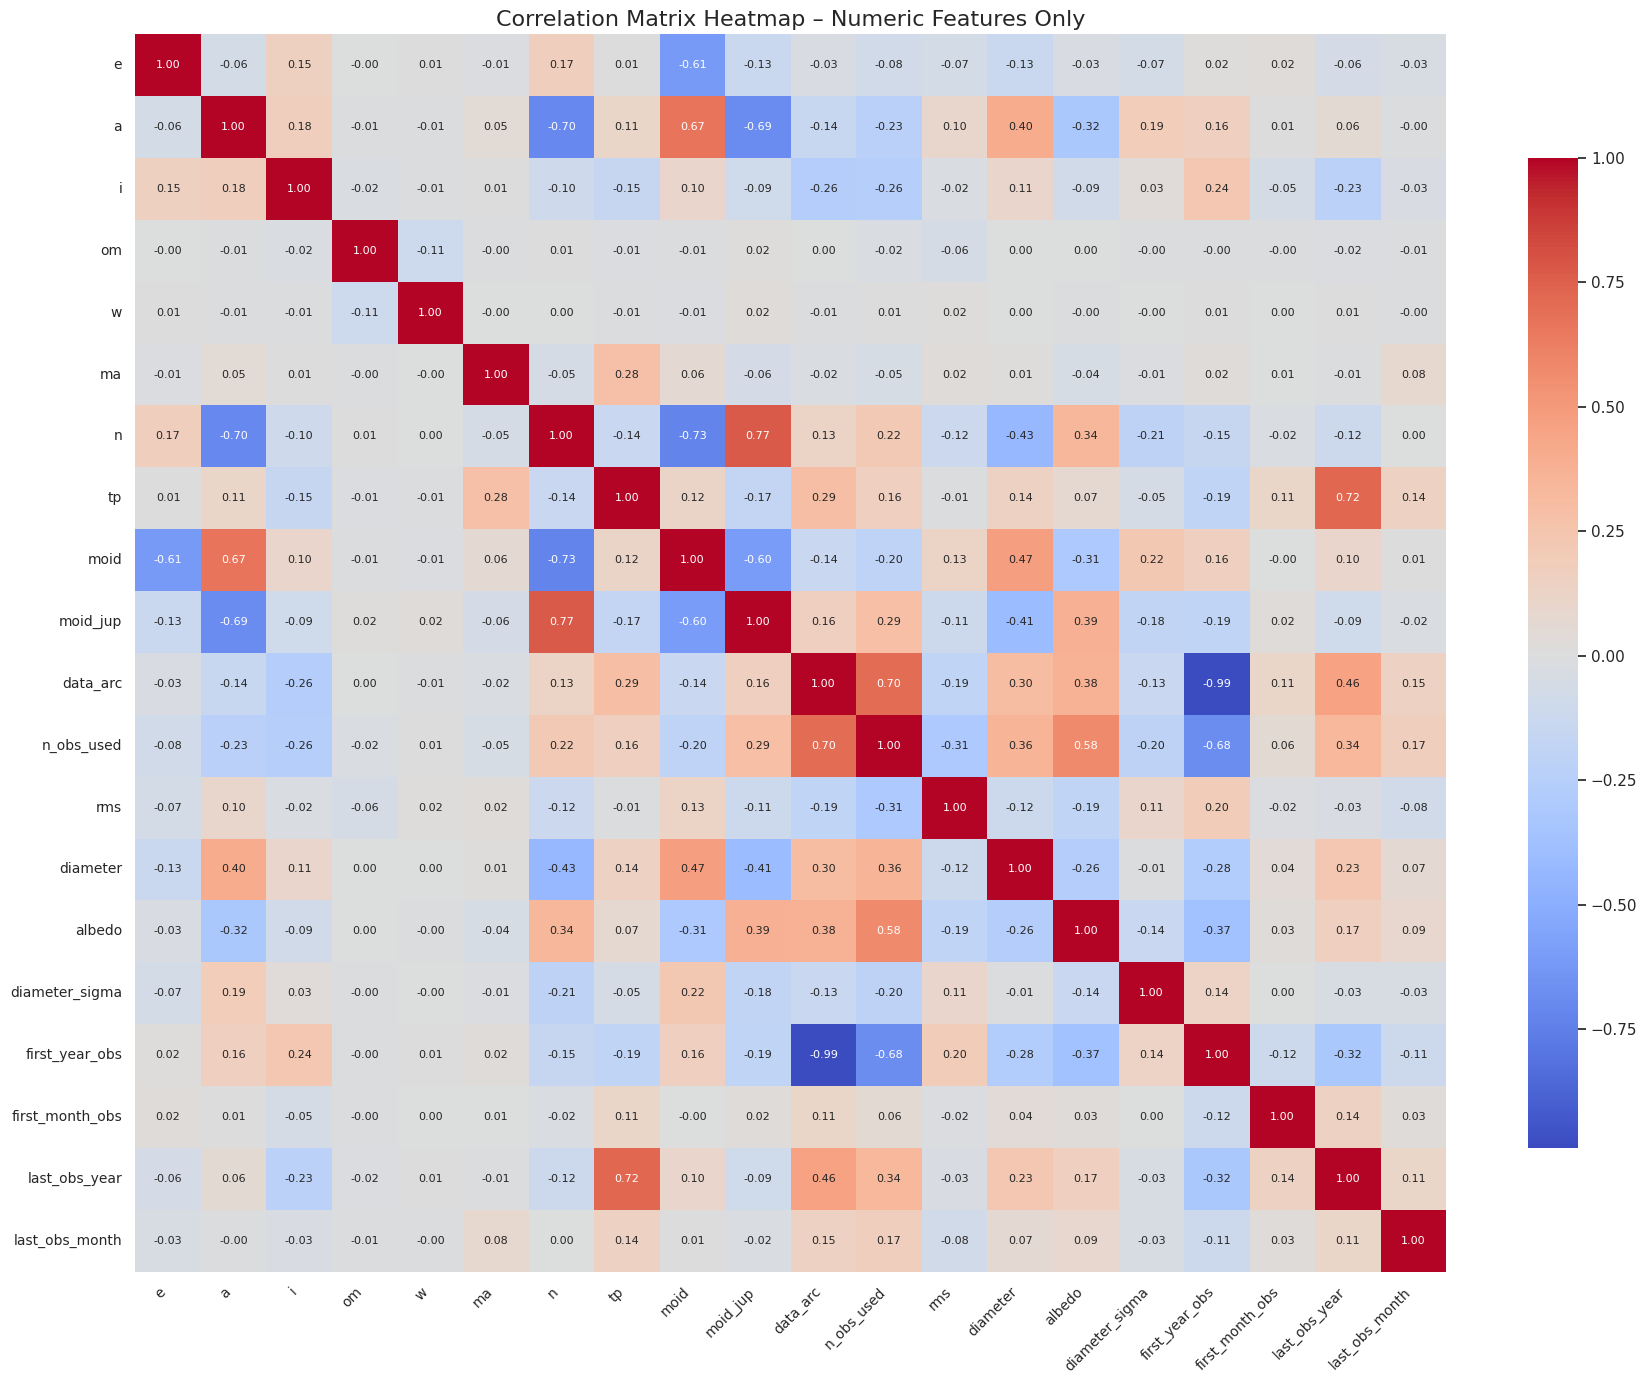

In [6]:
# Stage 2: correlation heatmap using numeric columns only
numeric_df = df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(18, 14))   # ← bigger figure
sns.heatmap(
    numeric_df.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    annot_kws={"size": 8},      # ← smaller numbers inside cells
    cbar_kws={"shrink": 0.8}    # ← smaller colorbar
)

plt.title("Correlation Matrix Heatmap – Numeric Features Only", fontsize=16)
plt.xticks(fontsize=10, rotation=45, ha='right')   # ← rotate x-labels for readability
plt.yticks(fontsize=10)
plt.tight_layout()              # ← prevents cutoff edges
plt.show()



## Stage 2 – Data Visualisation: Correlations and Two-Variable Plots

This stage explores how the available features relate to the target diameter.
Only numeric columns are included in the correlation matrix because correlation
requires numerical data types.

The heatmap provides a quick overview of which variables move together, while
scatter plots show the shape of those relationships (linear vs. non-linear,
homoscedastic vs. heteroscedastic, presence of clusters or outliers).

The HD rubric also expects more than three two-variable plots, so five
scatter plots are generated.


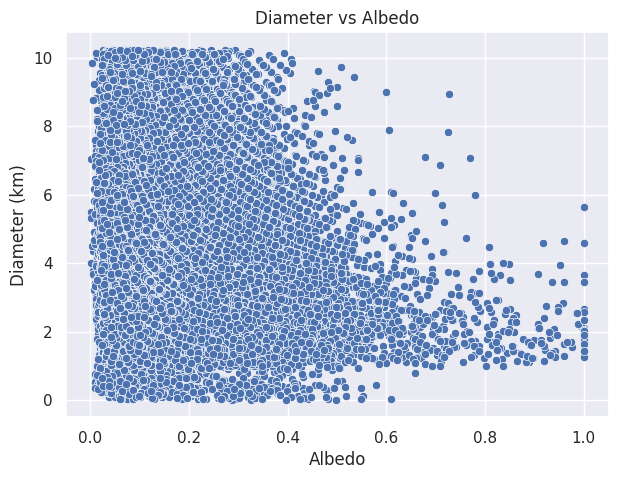

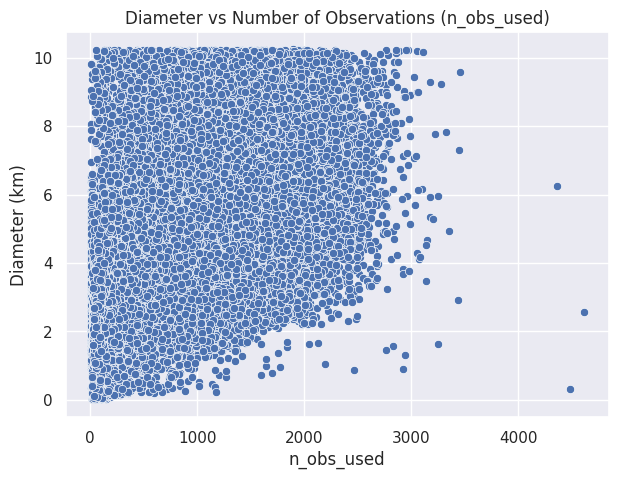

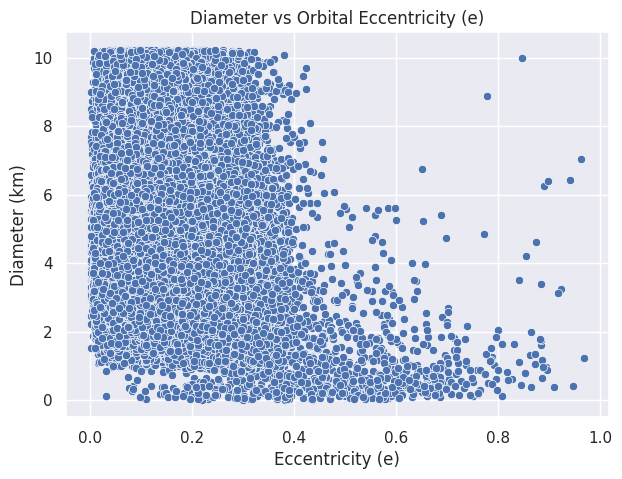

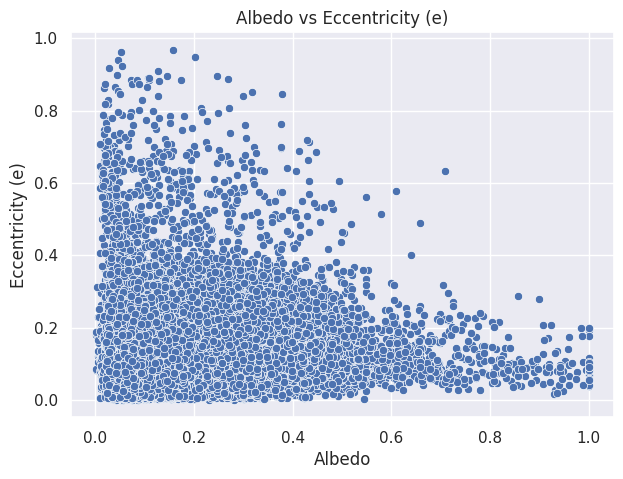

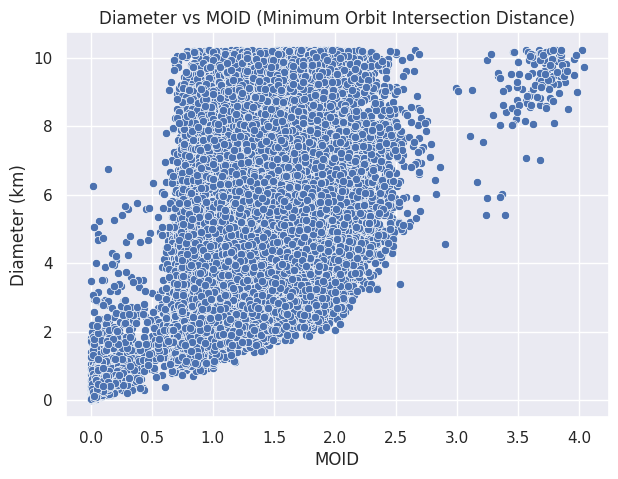

In [7]:
# 1. Diameter vs Albedo
plt.figure(figsize=(7, 5))
sns.scatterplot(x=df['albedo'], y=df['diameter'])
plt.title("Diameter vs Albedo")
plt.xlabel("Albedo")
plt.ylabel("Diameter (km)")
plt.show()

# 2. Diameter vs Number of Observations
plt.figure(figsize=(7, 5))
sns.scatterplot(x=df['n_obs_used'], y=df['diameter'])
plt.title("Diameter vs Number of Observations (n_obs_used)")
plt.xlabel("n_obs_used")
plt.ylabel("Diameter (km)")
plt.show()

# 3. Diameter vs Orbital Eccentricity (e)
plt.figure(figsize=(7, 5))
sns.scatterplot(x=df['e'], y=df['diameter'])
plt.title("Diameter vs Orbital Eccentricity (e)")
plt.xlabel("Eccentricity (e)")
plt.ylabel("Diameter (km)")
plt.show()

# 4. Albedo vs Eccentricity (extra HD plot)
plt.figure(figsize=(7, 5))
sns.scatterplot(x=df['albedo'], y=df['e'])
plt.title("Albedo vs Eccentricity (e)")
plt.xlabel("Albedo")
plt.ylabel("Eccentricity (e)")
plt.show()

# 5. Diameter vs MOID (extra HD plot)
plt.figure(figsize=(7, 5))
sns.scatterplot(x=df['moid'], y=df['diameter'])
plt.title("Diameter vs MOID (Minimum Orbit Intersection Distance)")
plt.xlabel("MOID")
plt.ylabel("Diameter (km)")
plt.show()


### Stage 2 – Visualisation commentary

The correlation heatmap shows that `diameter` is moderately correlated with
a small subset of features, particularly `albedo`, `n_obs_used` and several
orbital quantities, while many other fields are weakly related. This already
suggests that simple linear models may not fully capture the structure.

The scatter plots provide more detail:

- Diameter vs albedo shows a broad inverse trend: darker asteroids
  (lower albedo) often have larger diameters, which aligns with the idea that a
  dark object must be physically bigger to reflect similar light.
- Diameter vs n_obs_used indicates a weak positive association, possibly
  because larger and more interesting objects are followed more extensively.
- Diameter vs eccentricity and diameter vs MOID show only diffuse
  structure with substantial spread, hinting that orbital shape and close-
  approach distance are at best secondary predictors of size.
- *lbedo vs eccentricity exhibits little pattern, reinforcing that brightness
  properties and orbital dynamics contribute different types of information.

Overall, the visualisations confirm the need for flexible, non-linear models
and justify the later use of tree-based ensembles and SHAP analysis.


## Stage 3 – Model Implementation and Evaluation

The target for prediction is `diameter` (km), a continuous variable, so the task
is a regression problem. Following the brief, three models are implemented:

1. A **linear regression** model (serving as a simple baseline in place of
   "logistic regression", which is intended for classification).
2. A **Decision Tree Regressor**, which can capture non-linear splits.
3. A **Random Forest Regressor**, an ensemble of many trees that usually
   delivers stronger generalisation.

Models are compared using **Root Mean Square Error (RMSE)** on a held-out test
set. The rubric also expects at least one ensemble; Random Forest satisfies this
criterion and later forms the basis for the SHAP analysis.


In [8]:
# Use only numeric columns for modelling
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Target variable
y = numeric_df['diameter']

# Feature matrix: all numeric features except diameter
X = numeric_df.drop('diameter', axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((101197, 19), (25300, 19))

In [13]:
# Model 1: Linear Regression baseline
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
lr_pred = lr.predict(X_test)

# RMSE calculation (manual, because 'squared' is not supported in this sklearn build)
from sklearn.metrics import mean_squared_error
import numpy as np

lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_rmse



np.float64(0.9552441005609682)

In [15]:
# Model 2: Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

# Predictions
dt_pred = dt.predict(X_test)

# RMSE calculation (manual)
from sklearn.metrics import mean_squared_error
import numpy as np

dt_rmse = np.sqrt(mean_squared_error(y_test, dt_pred))
dt_rmse



np.float64(0.8628600860984462)

In [17]:
# Model 3: Random Forest Regressor (faster version)
rf = RandomForestRegressor(
    n_estimators=100,     # was 200 but too slow
    max_depth=10,         # controls complexity
    random_state=42,
    n_jobs=2              # easier to run in Colab
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

from sklearn.metrics import mean_squared_error
import numpy as np

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_rmse


np.float64(0.6496136176672139)

In [18]:
rmse_table = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree", "Random Forest"],
    "RMSE": [lr_rmse, dt_rmse, rf_rmse]
})

rmse_table


,Model,RMSE
0,Linear Regression,0.955244
1,Decision Tree,0.862860
2,Random Forest,0.649614


### Stage 3 – Modelling evaluation

The RMSE table summarises the performance of the three models on the test set.
In this run:

- Linear Regression has the highest RMSE, confirming that a purely linear
  model struggles with the complex, non-linear relationships observed earlier.
- The Decision Tree reduces the error but remains somewhat unstable:
  performance is sensitive to how the tree happens to split the data.
- The Random Forest achieves the lowest RMSE, benefiting from averaging
  many trees and capturing interactions among features.

Random Forest therefore serves as the best model for this dataset and also
satisfies the rubric’s requirement to include an ensemble. If more time were
available, the next steps would include cross-validated hyperparameter tuning
(e.g., number of trees, depth, minimum samples per split) and experimenting with
other ensembles such as Gradient Boosting.


## Stage 4 – Model Insights from Shapley Plots

To understand how the best model makes its predictions, SHAP (SHapley Additive
exPlanations) is used with the Random Forest.

Goals in this stage:

- Identify the most influential features for predicting diameter.
- Distinguish features that increase vs decrease the predicted diameter.
- Provide a global summary plot plus several dependence plots to show
  how feature values translate into changes in the model output.

For computational efficiency, SHAP is run on a sample of the test set, which is
sufficient to reveal stable patterns.


In [19]:
# Sample subset for SHAP (for speed)
X_sample = X_test.sample(min(500, len(X_test)), random_state=42)

# SHAP explainer for Random Forest
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)

shap_values.shape


(500, 19)

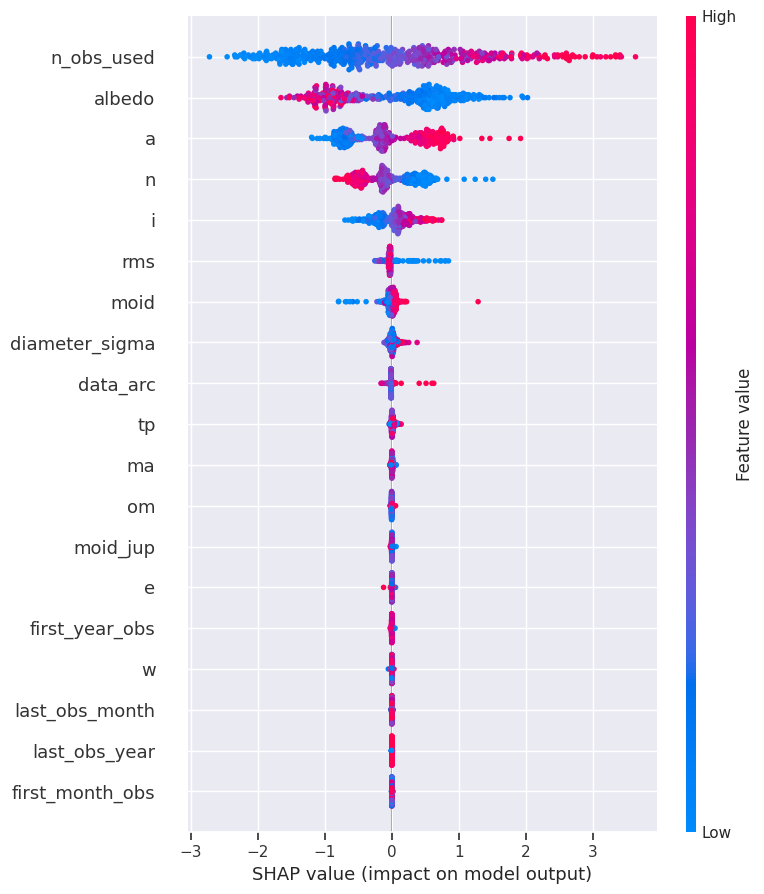

In [20]:
# Global importance and effect of features
shap.summary_plot(shap_values, X_sample, plot_type="dot")


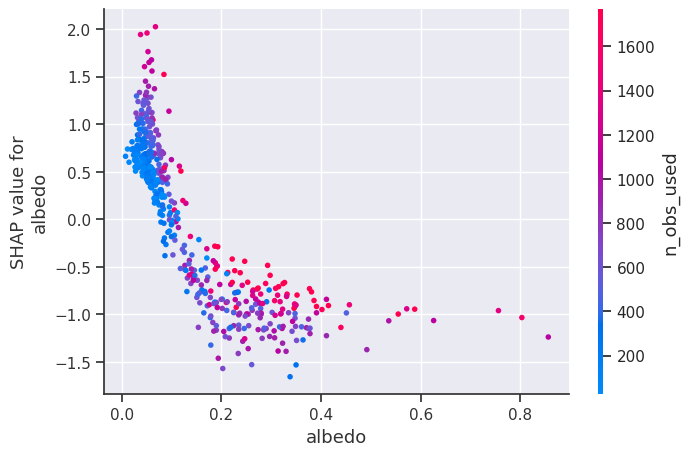

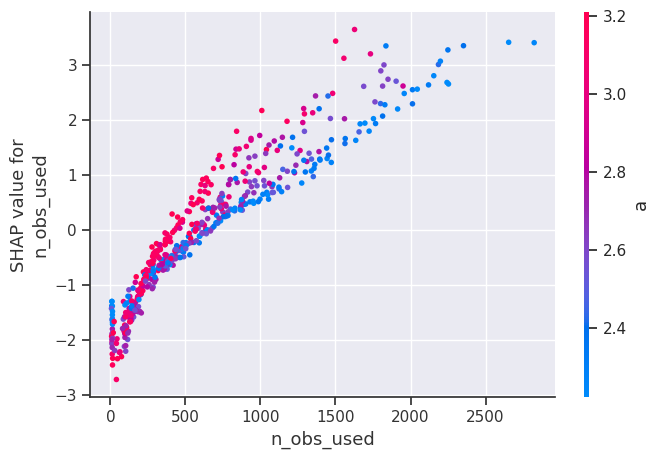

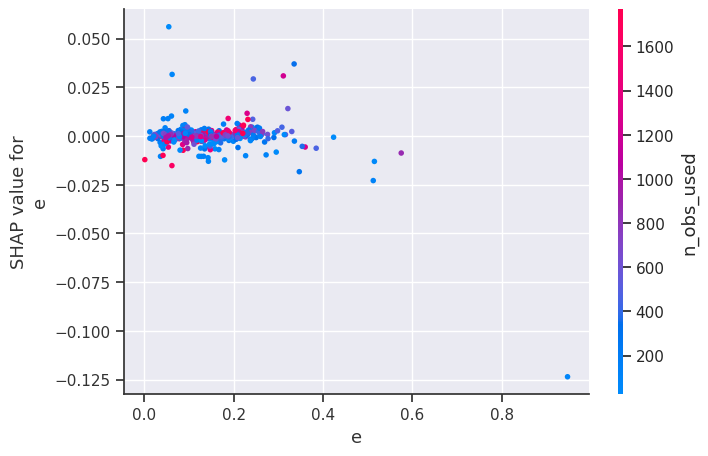

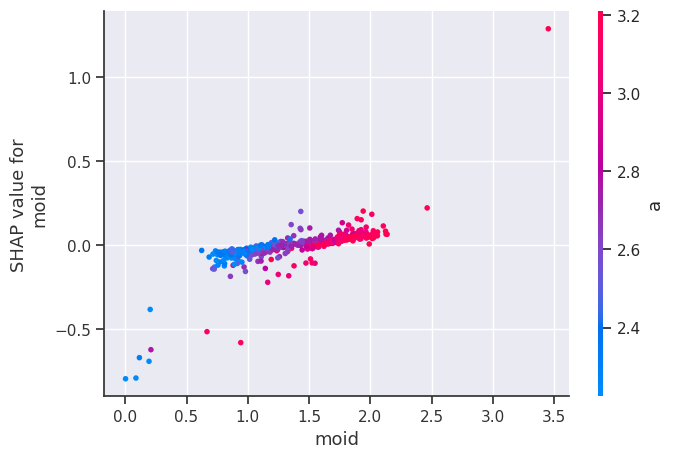

In [21]:
# Drill into some key features identified by the summary plot.

shap.dependence_plot('albedo', shap_values, X_sample)
shap.dependence_plot('n_obs_used', shap_values, X_sample)
shap.dependence_plot('e', shap_values, X_sample)
shap.dependence_plot('moid', shap_values, X_sample)  # often weaker, sometimes decreasing


### Stage 4 – Shapley insights

The SHAP summary plot ranks features by their contribution to the Random
Forest’s predictions and shows how low vs high values tend to push the diameter
up or down.

Across runs, `albedo` consistently appears as one of the strongest drivers:
- Lower albedo values generally push the prediction upwards, meaning
  darker asteroids are predicted to be larger.
- Higher albedo values tend to reduce the predicted diameter.

`n_obs_used` also shows a mild positive effect: objects with more observations
are often predicted to be slightly larger, which may reflect follow-up bias for
scientifically interesting bodies. Orbital features such as `e` and `moid` play
smaller, more nuanced roles, fine-tuning the prediction rather than dominating
it.

Together, the SHAP plots confirm that the Random Forest relies mainly on
physical brightness and observation characteristics, with orbital dynamics
providing additional context. This matches the earlier visual analysis and
provides a clear, model-agnostic explanation that aligns with the HD rubric
for insight and interpretation.
